Analýza Gaussovy křivky
-----------------
nalezení středu rozdělení (předpoklad normálnosti) s odhadem nejistot

předpokládáme profil histogramu BEZ POZADÍ 
$$D \exp(-(x-\mu)^2/(2\sigma^2)),$$ po zlogaritmování dostáváme polynom 2. řádu

$$\log D -\mu^2/(2\sigma^2) + x \mu/\sigma^2 - x^2 /(2\sigma^2)$$

pro nafitování polynomem $\sum_{i=0}^2 p_i x^i$ dostaneme pro parametry gausovky

$$\sigma^2=-\frac{1}{2 p_2} \\
\mu=-\frac{p_1}{2 p_2} \\
\log D = p_0 + \frac{p_1^2}{4 p_2}$$

Problémem polynomu v zákl. tvaru jsou silné korelace mezi parametry $p_i$.  
Otázka korelace je řešena ortogonalizací polynomů, viz <http://nymeria.physics.muni.cz/face/praxis/doc/mmzm_ortopolynom/?jax=1>.

#### nalezení ortonormálních polynomů 

ortogonalizace na intervalu <-1,1>

$$\int_{-1}^1{g_i(x) g_j(x) d x} = \delta_{ij}$$
(6 rovnic) 
dá renorm. Legendrovy polynomy

$$g_0=\sqrt{1/2} \\
g_1=\sqrt{3/2}x \\
g_2=\sqrt{5/8} (3x^2-1)$$

Pozn.: někdy uváděná dodatečná normaliz. podmínka
$$\int_{-1}^1{g_i(x) d x} = 0$$ vyplyne z předchozího pro $j>0$, pokud $g_0=\rm{const}$ .

In [19]:
%matplotlib inline
from matplotlib.pyplot import *
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]
import numpy as np
a,b=[2,4.]
y=np.r_[a:b:41j]
x=2*y/(b-a) - (a+b)/(b-a)
def mat_Leg(x):
    g_0=np.sqrt(1/2.)*ones(x.shape)
    g_1=np.sqrt(3/2.)*x
    g_2=np.sqrt(5/8.)*(3*x**2-1)
    return r_[[g_0,g_1,g_2]]

aplikace na lib. interval $(a,b)$ lze provést transformací $y=(a+b)/2 + x (b-a)/2$, resp. dosazením $x=2y/(b-a) - (a+b)/(b-a) = y c - d$:
$$h_1 = \sqrt{3/2} (yc-d)\\
h_2 = \sqrt{5/8} (3c y^2 - 6cd y +3d^2-1) $$

Najdeme-li (téměř) nekorelované koeficienty $k_i$ pro polynomy $h_i(x)$, koeficienty pro počáteč. polynomy $x^i$ dostaneme maticovými operacemi, kdy zavedeme

$$g_i(x)=\sum_j G_{ij} x^j$$ kde

$$G_{ij}=\left( \begin{array}{ccc} \sqrt{1/2} & 0 & 0 \\
0 & \sqrt{3/2} & 0 \\
-\sqrt{5/8} & 0 & \sqrt{45/8}\end{array}\right)$$

$$h_i(y)=\sum_j G_{ij} (cy-d)^j = \sum_j H_{ij} y^j= \sum_j \sum_k T_{ik} G_{kj} y^j$$.

Prvky matice $T_{ij}$ vycházejí z kombin. čísel, potom model logaritmu fitované gausovky vychází
$f(y) = \sum_i k_i h_i(y)= \sum_i k_i  \sum_j \sum_k T_{ik} G_{kj} y^j$, tedy koeficienty $p_j$ dostaneme jako 
$$p_j= \sum_k \sum_i k_i T_{ik} G_{kj}$$.

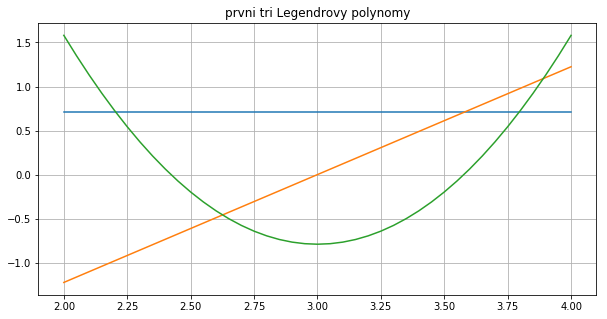

In [20]:
# v maticovem zapisu je to jednodussi
matG=np.sqrt(np.r_[[[0.5,0,0],[0,1.5,0],[5/8.,0,45/8.]]])
matG[2][0]*=-1
mat_poly2=lambda x:np.r_[[x**i for i in range(3)]] #obyčejné mocniny
mat_Leg2=lambda x:np.dot(matG,mat_poly2(x)) #Legendrovy polynomy - alternativa k mat_Leg
[plot(y,a) for a in mat_Leg2(x)]
title("prvni tri Legendrovy polynomy")
grid()

In [25]:
from numpy.random import normal
from numpy import r_,array,ones
# transformacni matice polynomu pri presunu intervalu
def mat_trans(c,d,n=2):
    rep=[[1]+[0]*n]
    from scipy.special import comb
    clin=c**r_[:n+1]
    dlin=d**r_[n:-1:-1]
    for i in range(1,n+1):
        #lin=[factorial(i)/factorial(j)/factorial(i-j)*(c**j)*(d**(i-j)) for j in range(i)]
        lin=comb(ones(i+1)*i,r_[:i+1])*clin[:i+1]*dlin[-i-1:]
        rep.append(list(lin)+[0]*(n-i))
    return array(rep)
a,b=2,4
F=mat_trans(2/(b-a),-(b+a)/(b-a),2)
F


array([[ 1.,  0.,  0.],
       [-3.,  1.,  0.],
       [ 9., -6.,  1.]])

## Simulace - normálně rozděl. data a rekonstrukce

funkce `pokus` vrací rekonstruované parametry, kovarianční matici, střední hodnotu a směrod. odchylku, ev. i hodnoty histogramu

In [44]:
# generovani normalne rozdel. nahodnych cisel
from numpy import histogram,dot,log,exp,polyfit,polyval,sqrt
from numpy.linalg import inv
def pokus(dsize=500,a=2,b=4,step=0.05,full=0):
    data=normal((a+b)/2.,(b-a)/4.,size=dsize) # interval pokryje -2sigma - +2sigma
    z=r_[(a-step/2):(b+step/2):step]
    x=2*z/(b-a) - (a+b)/(b-a)
    A=mat_Leg2((x[1:]+x[:-1])/2)
    #print A.shape
    v,z=histogram(data,z)
    H=dot(A,A.transpose())
    D=inv(H)
    res=dot(D,dot(A,log(v)))
    if full==3: return res,D,data.mean(),data.std(),v,z
    if full==2: return res,D,data.mean(),data.std()
    if full==1: return res,D
    return res

In [37]:
from numpy import corrcoef
res,D,mu,st,v,z=pokus(dsize=500,full=3,step=0.1)
polres,polcov=polyfit((z[:-1]+z[1:])/2.,log(v),2,cov=True) # alternativne normalni polynomialni fit
err=np.sqrt(D.diagonal())
R=D/err[:,np.newaxis]/err[np.newaxis,:]
R #korelacni matice ortogonaliz. polynomu

array([[1.        , 0.08693164, 0.01120797],
       [0.08693164, 1.        , 0.19104018],
       [0.01120797, 0.19104018, 1.        ]])

In [39]:
polerr=np.sqrt(polcov[::-1,::-1].diagonal())
polcorr=polcov[::-1,::-1]/polerr[:,np.newaxis]/polerr[np.newaxis,:]
polcorr
#polerr/polres[::-1]

array([[ 1.        , -0.99514148,  0.98339914],
       [-0.99514148,  1.        , -0.99622942],
       [ 0.98339914, -0.99622942,  1.        ]])

In [43]:
rsid=((np.polyval(polres,(z[:-1]+z[1:])/2.)-log(v))**2).sum()
sig=np.sqrt(rsid/(len(z)-1-3))
sig

0.2316147791773176

In [44]:
err/res*sig

array([ 0.01727503, -2.71395582, -0.08797732])

#### aplikace Legendrovych polynomu

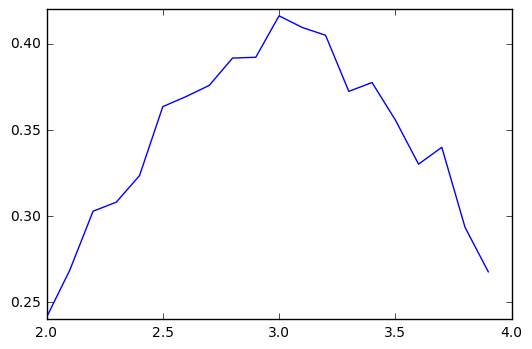

In [7]:
from scipy import stats
xs=r_[2:4:0.1]
y=stats.norm(3,1).pdf(xs)+stats.norm(0,0.01).rvs(size=len(xs))
plot(xs,y)
A=mat_Leg2(2*xs/(b-a) - (a+b)/(b-a))
D=inv(A.dot(A.T))
#ted analyzu 500x zopakujeme
rall=array([A.dot(log(stats.norm(3,1).pdf(xs)+stats.norm(0,0.01).rvs(size=len(xs)))) for i in range(500)])

In [8]:
corrcoef(rall[:,0],rall[:,1])[1,0],corrcoef(rall[:,0],rall[:,2])[1,0],corrcoef(rall[:,1],rall[:,2])[1,0]

(-0.086801991223572864, 0.2190241521981868, -0.24733020472468203)

In [26]:
rall.std(0) #smerod. odchylka jednotlivych parametru

array([ 0.09349273,  0.10337155,  0.10909491])

Text(0.5,1,'Legendr. polynomy vyssich radu')

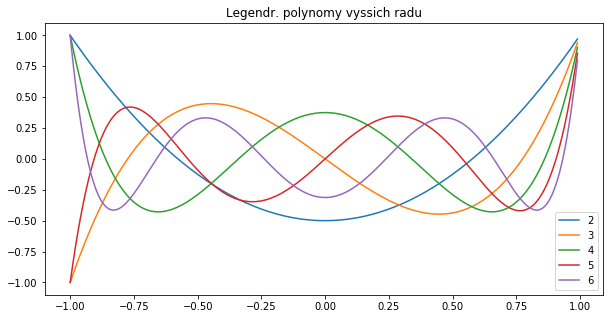

In [40]:
from numpy.polynomial import legendre as pc

x=np.r_[-1:1:0.01]
[plot(x,pc.Legendre([0]*i+[1])(x)) for i in range(2,7)]
legend(range(2,7))
title("Legendr. polynomy vyssich radu")

### rekapitulace

fit Legend. polynomy (po transformaci): [-16.78698427  13.65041352  -2.27028983]
fit mocninami: [-16.78698427  13.65041352  -2.27028983]
korelační matice.. 
 [[1.         0.08693164 0.01120797]
 [0.08693164 1.         0.19104018]
 [0.01120797 0.19104018 1.        ]]
korelační matice..(po transformaci) 
 [[1.         0.98560734 0.95097407]
 [0.98560734 1.         0.98734087]
 [0.95097407 0.98734087 1.        ]]


array([[ 1.        , -0.99514148,  0.98339914],
       [-0.99514148,  1.        , -0.99622942],
       [ 0.98339914, -0.99622942,  1.        ]])

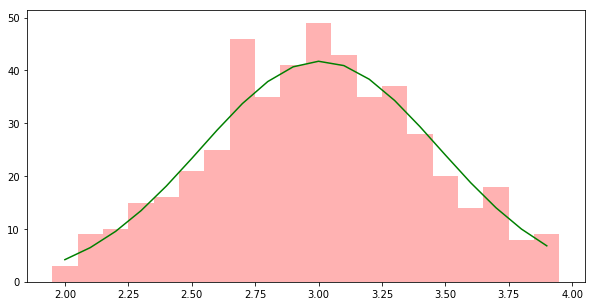

In [46]:
zz=(z[:-1]+z[1:])/2.
bar(zz,v,0.1,color='r',alpha=0.3)
a,b=2,4
#xx=2*zz/(b-a) - (a+b)/(b-a)
F=mat_trans(2/(b-a),-(b+a)/(b-a),2)#.transpose()
#m1=mat_poly2(xx)
polym2=mat_poly2(zz)
T=matG.dot(F)
A=T.dot(polym2)
newres=res.dot(T)
### transformace zpet do prostoru obyc. polynomu
newD=inv(T.dot(inv(D).dot(T.T)))
newsig=sqrt(newD.diagonal())
newrho=newD/(newsig.reshape(3,1)*newsig.reshape(1,3))
D2=inv(dot(polym2,polym2.transpose()))
sig2=sqrt(D2.diagonal())
rho2=D2/(sig2.reshape(3,1)*sig2.reshape(1,3))
#plot(zz,exp(dot(res,A)),'r',hold=1)
plot(zz,exp(dot(newres,polym2)),'g')
print("fit Legend. polynomy (po transformaci):",newres)
print("fit mocninami:",polres[::-1])
sig=sqrt(D.diagonal())
print("korelační matice.. \n",D/(sig.reshape(3,1)*sig.reshape(1,3)))
print("korelační matice..(po transformaci) \n",newrho)
rho2

původně nekorelované parametry jsou opět provázány...

### opakování simulace - rozdělení rekonstruovaných parametrů

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


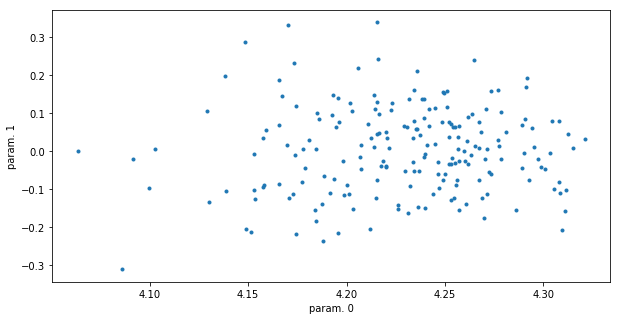

In [49]:
if True: #případně vypneme, pokud chceme ušetřit čas
    rep=[pokus(full=2,step=0.1) for i in range(200)]
    mux,sigx=array([r[2:] for r in rep]).transpose() #prumer a stredni hodnota
    pask1=array([r[0] for r in rep]).transpose() #parametry z histogramu
    plot(pask1[0],pask1[1],'.')
    xlabel("param. 0")
    ylabel("param. 1")

In [50]:
sel=(pask1[0]>0)*(pask1[1]+10>0)*(pask1[2]+10>0)
pask1=pask1[:,sel]
sum(sel)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


198

Text(0,0.5,'sigma')

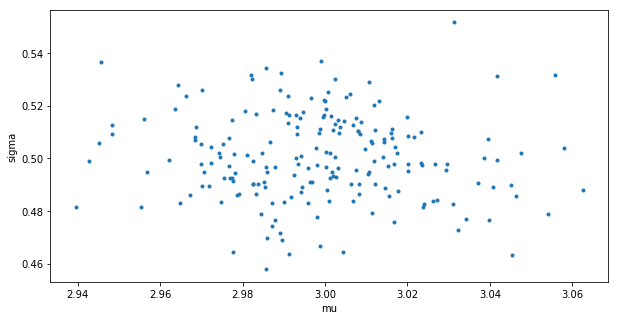

In [51]:
plot(mux,sigx,'.')
xlabel('mu')
ylabel('sigma')

In [54]:
corrcoef(mux,sigx)[0,1]

-0.06950556442590902

korelace mezi odhadem střední hodnoty a rozptylu na úrovni 8%

korelace 1,2: 0.045105565873923156
korelace 0,2: 0.9171578199385589


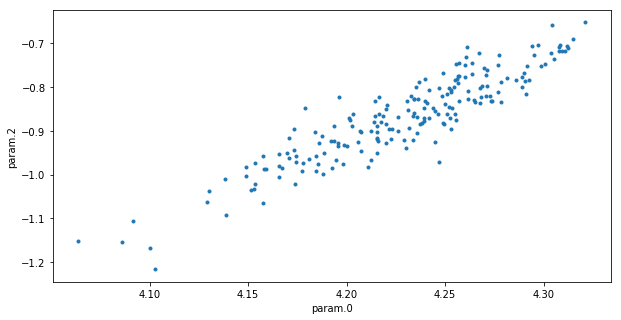

In [62]:
plot(pask1[0],pask1[2],'.')
xlabel("param.0")
ylabel("param.2")
print("korelace 1,2:",corrcoef(pask1[2],pask1[1])[0,1])
print("korelace 0,2:",corrcoef(pask1[0],pask1[2])[0,1])

#### testovací otázka - proč je parametr 0 korelován s 2 ?
(hint: vzorce v úvodu) 

### přepočet na parametry norm. rozdělení

Text(0,0.5,'est. sigma')

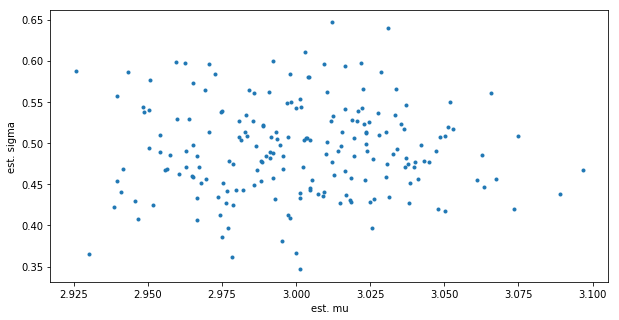

In [58]:
pask2=dot(pask1.transpose(),T).transpose()
estmu=-pask2[1]/2./pask2[2]
estsigma=-1/pask2[2]
plot(estmu,estsigma,'.')
xlabel('est. mu')
ylabel('est. sigma')

(-33.41713154465355, 4.293518519088544)

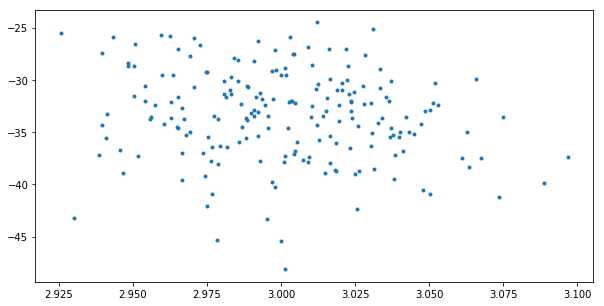

In [59]:
estamp=pask2[0]+pask2[1]**2/4/pask2[2]
plot(estmu,estamp,'.')
estamp.mean(),estamp.std()

In [60]:
print("korelace urcenych parametru:",corrcoef(estmu,estsigma)[0,1])
(mux.std(),estmu.std()),(sigx.std(),estsigma.std())

korelace urcenych parametru: 0.00034128037287813897


((0.023331361105216716, 0.03305238767076496),
 (0.0164531770902861, 0.05591150621188542))

In [61]:
r_[1,1e4,1e2].dot(T)

array([-34686.15855586,  10824.42376684,    237.17082451])

0.707*p1 - 3.67*p2 + 20.5*p3
1.22*p2 - 14.23*p3
2.37*p3

In [46]:
T

array([[  0.70710678,   0.        ,   0.        ],
       [ -3.67423461,   1.22474487,   0.        ],
       [ 20.55480479, -14.23024947,   2.37170825]])